In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.api import VAR

In [3]:
velocity_M1 = pd.read_csv('data/M1V.csv', index_col = 0)
velocity_M1.index = pd.to_datetime(velocity_M1.index)

velocity_M2 = pd.read_csv('data/M2V.csv', index_col = 0)
velocity_M2.index = pd.to_datetime(velocity_M2.index)

# velocity_M1 = velocity_M1.resample('m').mean().loc[:'2018']
# velocity_M2 = velocity_M2.resample('m').mean().loc[:'2018']

In [4]:
mkt_cap = pd.read_csv('data/market_cap_usa.csv', sep = ';')
mkt_cap = mkt_cap.T.loc['1980':'2018']
mkt_cap.columns = ['MktCap']
mkt_cap.index = pd.to_datetime(mkt_cap.index)
mkt_cap['MktCap'] = mkt_cap['MktCap'].astype(float)

In [5]:
mkt_cap_wilshire = pd.read_csv('data/wilshire_marketcap_index.csv', index_col = 0)
mkt_cap_wilshire = mkt_cap_wilshire.loc['1980':'2018']
mkt_cap_wilshire.columns = ['MktCap']
mkt_cap_wilshire.index = pd.to_datetime(mkt_cap_wilshire.index)
mkt_cap_wilshire.replace('.', np.nan, inplace = True)
mkt_cap_wilshire['MktCap'] = mkt_cap_wilshire['MktCap'].astype(float)

mkt_cap_wilshire = mkt_cap_wilshire.resample('m').first()
mkt_cap_wilshire

,MktCap
DATE,
1980-04-30,1.77
1980-05-31,1.86
1980-06-30,1.98
1980-07-31,2.07
1980-08-31,2.20
...,...
2017-08-31,113.90
2017-09-30,114.08
2017-10-31,117.04


In [6]:
m2_data = pd.read_csv('data/M2_money_stock.csv', index_col = 0)
m1_data = pd.read_csv('data/M1_money_stock.csv', index_col = 0)
m0_data = pd.read_csv('data/monetary_base_curr_in_circulation.csv', index_col = 0)
gdp_data = pd.read_csv('data/GDP.csv', index_col = 0)

m2_data.index = pd.to_datetime(m2_data.index)
m2_data.columns = ['M2']
m2_data = m2_data.resample('m').mean().loc[:'2018']

m1_data.index = pd.to_datetime(m1_data.index)
m1_data.columns = ['M1']
m1_data = m1_data.resample('m').mean().loc[:'2018']

m0_data.index = pd.to_datetime(m0_data.index)
m0_data.columns = ['M0']
m0_data = m0_data.resample('m').mean().loc[:'2018']

gdp_data.index = pd.to_datetime(gdp_data.index)
gdp_data.columns = ['GDP']
# gdp_data = gdp_data.resample('Y').mean().loc[:'2018']

In [7]:
inflation_data = pd.read_csv('data/CPIAUCSL.csv', index_col = 0)
inflation_data.index = pd.to_datetime(inflation_data.index)
inflation_data.columns = ['inflation']

In [8]:
# inflation_data_r = inflation_data.resample('Y').last()

In [15]:
test_data = inflation_data.join(mkt_cap_wilshire, how = 'outer')
test_data['inflation'] = test_data['inflation'].fillna(method = 'bfill')
test_data = test_data.dropna()

test_data = test_data.join(m2_data)
test_data = test_data.join(m1_data)
test_data = test_data.join(m0_data)
test_data = test_data.join(gdp_data, how = 'outer')
test_data[['inflation', 'MktCap', 'M2', 'M1', 'M0']] = test_data[['inflation', 'MktCap', 'M2', 'M1', 'M0']].fillna(method = 'ffill')
test_data.dropna(inplace = True)
test_data = test_data.join(velocity_M1)
test_data = test_data.join(velocity_M2)

In [16]:
test_data = test_data.loc[:'2017']

In [17]:
test_data_log_diff = np.log(test_data) - np.log(test_data).shift(1)
test_data_log_diff = test_data_log_diff.dropna()
for col in test_data_log_diff.columns:
    print(col, adfuller(test_data_log_diff[col].values)[1])

inflation 5.706597478273094e-16
MktCap 2.594532925202618e-22
M2 0.006598419773510049
M1 0.07861029714057115
M0 0.008973046200918756
GDP 2.3334703052535738e-05
M1V 2.0548316651585152e-06
M2V 8.445109729402025e-09


In [11]:
test_data_log_diff['MktCap'].tail(10)

DATE
2015-07-01    0.002763
2015-10-01   -0.093730
2016-01-01    0.085417
2016-04-01   -0.067625
2016-07-01    0.072962
2016-10-01    0.042617
2017-01-01    0.020397
2017-04-01    0.091441
2017-07-01    0.017183
2017-10-01    0.022606
Name: MktCap, dtype: float64

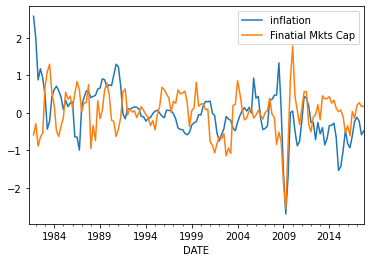

In [25]:
import matplotlib.pyplot as plt
infl = test_data['inflation'].pct_change().dropna()
mkt = test_data['MktCap'].pct_change().dropna()

infl = ((infl-infl.mean())/infl.std()).rolling(window = 3).mean()
mkt = ((mkt-mkt.mean())/mkt.std()).rolling(window =3).mean()

infl.plot(label = 'inflation')
mkt.plot(label = 'Finatial Mkts Cap')
plt.legend()

## Granger Causality

In [12]:
data = test_data_log_diff[['inflation', 'MktCap']]
gc_res = grangercausalitytests(data, 3)
gc_res


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0137  , p=0.3157  , df_denom=143, df_num=1
ssr based chi2 test:   chi2=1.0350  , p=0.3090  , df=1
likelihood ratio test: chi2=1.0313  , p=0.3098  , df=1
parameter F test:         F=1.0137  , p=0.3157  , df_denom=143, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2931  , p=0.7464  , df_denom=140, df_num=2
ssr based chi2 test:   chi2=0.6070  , p=0.7382  , df=2
likelihood ratio test: chi2=0.6058  , p=0.7387  , df=2
parameter F test:         F=0.2931  , p=0.7464  , df_denom=140, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1082  , p=0.9552  , df_denom=137, df_num=3
ssr based chi2 test:   chi2=0.3412  , p=0.9521  , df=3
likelihood ratio test: chi2=0.3408  , p=0.9522  , df=3
parameter F test:         F=0.1082  , p=0.9552  , df_denom=137, df_num=3


{1: ({'ssr_ftest': (1.0137239892783276, 0.31571297592883135, 143.0, 1),
   'ssr_chi2test': (1.0349909261163346, 0.30898931843072186, 1),
   'lrtest': (1.0313396573633327, 0.30984422827177427, 1),
   'params_ftest': (1.013723989278329, 0.31571297592883135, 143.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.2930549465415515, 0.746437629448656, 140.0, 2),
   'ssr_chi2test': (0.6070423892646424, 0.7382142427865401, 2),
   'lrtest': (0.6057752334154429, 0.7386821072330363, 2),
   'params_ftest': (0.29305494654155323, 0.7464376294486501, 140.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.1082201559268861, 0.9551718977242664, 137.0, 3),
   'ssr_chi2test': (0.3412489588351445, 0.9520928141484826, 3),
   'lrtest': (0.340845253270345, 0.9521721235254188, 3),
   'params_ftest': (0.10822015592688972, 0.9551718977242664, 137.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0

In [13]:
data_inv = test_data_log_diff[['MktCap', 'inflation']]
gc_res_inv = grangercausalitytests(data_inv, 3)
gc_res_inv


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2555  , p=0.6140  , df_denom=143, df_num=1
ssr based chi2 test:   chi2=0.2609  , p=0.6095  , df=1
likelihood ratio test: chi2=0.2606  , p=0.6097  , df=1
parameter F test:         F=0.2555  , p=0.6140  , df_denom=143, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2744  , p=0.1067  , df_denom=140, df_num=2
ssr based chi2 test:   chi2=4.7112  , p=0.0948  , df=2
likelihood ratio test: chi2=4.6362  , p=0.0985  , df=2
parameter F test:         F=2.2744  , p=0.1067  , df_denom=140, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3906  , p=0.0714  , df_denom=137, df_num=3
ssr based chi2 test:   chi2=7.5381  , p=0.0566  , df=3
likelihood ratio test: chi2=7.3474  , p=0.0616  , df=3
parameter F test:         F=2.3906  , p=0.0714  , df_denom=137, df_num=3


{1: ({'ssr_ftest': (0.2555070108029972, 0.614002067632887, 143.0, 1),
   'ssr_chi2test': (0.2608672977429202, 0.6095249348655831, 1),
   'lrtest': (0.2606345210512018, 0.6096845651597371, 1),
   'params_ftest': (0.2555070108029807, 0.6140020676329092, 143.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.2743543253725274, 0.1066515974021542, 140.0, 2),
   'ssr_chi2test': (4.711162531128806, 0.09483836423470172, 2),
   'lrtest': (4.636246273539427, 0.09845820488206251, 2),
   'params_ftest': (2.2743543253725127, 0.1066515974021557, 140.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.390552653730446, 0.0714029182625699, 137.0, 3),
   'ssr_chi2test': (7.538093039500385, 0.05658771499169016, 3),
   'lrtest': (7.347417548040994, 0.061611318241686856, 3),
   'params_ftest': (2.390552653730436, 0.07140291826257027, 137.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0

## VAR ANALYSIS

### VAR: inflation, MktCap

In [14]:
model = VAR(test_data_log_diff[['inflation', 'MktCap']])
results = model.fit(4)
results.summary()

/Users/felipe/anaconda/envs/fenicsproject/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 07, May, 2021
Time:                     09:06:01
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.7296
Nobs:                     143.000    HQIC:                  -14.9510
Log likelihood:           692.017    FPE:                2.76176e-07
AIC:                     -15.1026    Det(Omega_mle):     2.44440e-07
--------------------------------------------------------------------
Results for equation inflation
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.004800         0.001074            4.470           0.000
L1.inflation         0.190876         0.088732            2.151           0.031
L1.MktCap           -0.001800         0.005808           -0.

## VAR: inflation, M2, MktCap

In [15]:
model = VAR(test_data_log_diff[['inflation','M2', 'MktCap']])
results = model.fit(4)
results.summary()

/Users/felipe/anaconda/envs/fenicsproject/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 07, May, 2021
Time:                     09:06:01
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -23.6616
Nobs:                     143.000    HQIC:                  -24.1413
Log likelihood:           1179.85    FPE:                2.36392e-11
AIC:                     -24.4696    Det(Omega_mle):     1.82082e-11
--------------------------------------------------------------------
Results for equation inflation
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.004130         0.001694            2.438           0.015
L1.inflation         0.192486         0.091344            2.107           0.035
L1.M2                0.010096         0.055891            0.

## VAR: inflation, M2, GDP, MktCap

In [16]:
model = VAR(test_data_log_diff[['inflation','M2','GDP', 'MktCap']])
results = model.fit(4)
results.summary()

/Users/felipe/anaconda/envs/fenicsproject/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 07, May, 2021
Time:                     09:06:01
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -33.6074
Nobs:                     143.000    HQIC:                  -34.4438
Log likelihood:           1760.03    FPE:                6.23124e-16
AIC:                     -35.0163    Det(Omega_mle):     3.97593e-16
--------------------------------------------------------------------
Results for equation inflation
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.001491         0.001644            0.907           0.364
L1.inflation         0.123977         0.088167            1.406           0.160
L1.M2                0.001085         0.050407            0.

## VAR: inlfation, M2, GDP, MV2, MktCap

/Users/felipe/anaconda/envs/fenicsproject/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


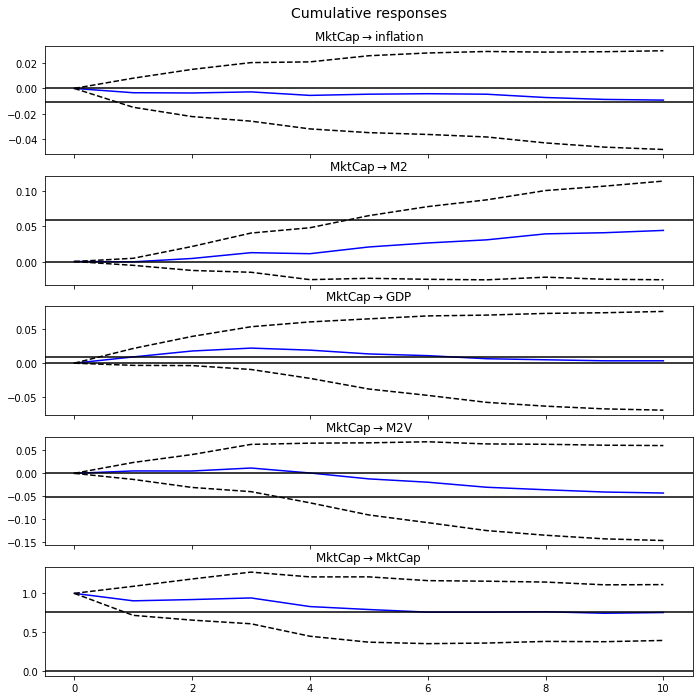

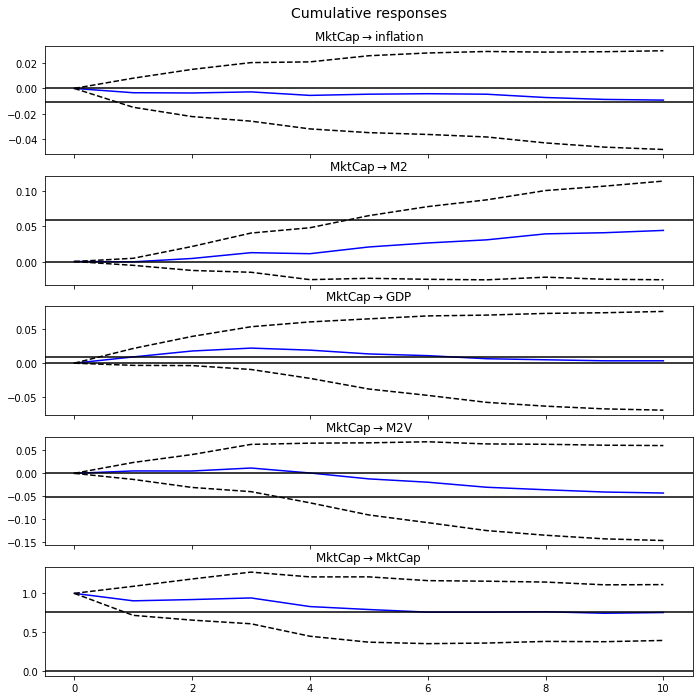

In [17]:
model = VAR(test_data_log_diff[['inflation','M2','GDP', 'M2V', 'MktCap']])
results = model.fit(5)
results.summary()
irf = results.irf(10)
irf.plot_cum_effects(orth=False, impulse='MktCap')

In [18]:
model = VAR(test_data_log_diff[['inflation','M2','GDP', 'M2V']])
results = model.fit(5)
results.summary()

/Users/felipe/anaconda/envs/fenicsproject/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 07, May, 2021
Time:                     09:06:05
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -41.3153
Nobs:                     142.000    HQIC:                  -42.3533
Log likelihood:           2335.57    FPE:                2.00176e-19
AIC:                     -43.0638    Det(Omega_mle):     1.15296e-19
--------------------------------------------------------------------
Results for equation inflation
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.002359         0.001670            1.412           0.158
L1.inflation         0.121538         0.091126            1.334           0.182
L1.M2                0.178437         0.206880            0.

In [19]:
data_shifted = test_data_log_diff[['M2', 'GDP', 'M2V']].shift(-1)
data_reg = data_shifted.join(test_data_log_diff['inflation'], how = 'inner').dropna()
model = ols("inflation ~ M2 + M2V + GDP", data_reg).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              inflation   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     3.521
Date:                Fri, 07 May 2021   Prob (F-statistic):             0.0167
Time:                        09:06:06   Log-Likelihood:                 540.59
No. Observations:                 146   AIC:                            -1073.
Df Residuals:                     142   BIC:                            -1061.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0054      0.001      3.705      0.000       0.003       0.008
M2            -0.1658      0.060     -2.748      0.007      -0.285      -0.047
M2V           -0.1848      0.078     -2.376      0.019      -0.339      -0.031
GDP            0.2934      0.110      2.676      0.008       0.077       0.510
==============================================================================
Omnibus:                       20.010   Durbin-Watson:                   1.492
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.533
Skew:                          -0.061   Prob(JB):                     6.62e-22
Kurtosis:                       7.002   Cond. No.                         262.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## SVAR -> R

In [20]:
# test_data_log_diff = (test_data_log_diff - test_data_log_diff.mean())/test_data_log_diff.std()
# test_data_log_diff = test_data_log_diff.loc['1982':]
# test_data_log_diff.to_csv('data/inflation_mktcap.csv')

### Residual VAR - with linear regression:

In [21]:
from sklearn.linear_model import LinearRegression

targets = ['M2','GDP', 'M2V']
feature = 'MktCap'
residual_df = pd.DataFrame(test_data['MktCap'])

for target in targets:
    x = test_data[feature].values.reshape(-1,1)
    y = test_data[target].values.reshape(-1,1)
    model = LinearRegression(fit_intercept = False).fit(x,y)
    residuas = y - model.predict(y)
    residuas_series = pd.DataFrame(residuas)
    residuas_series.index = residual_df.index
    residuas_series.columns = [target]
    residual_df = residual_df.join(residuas_series)
    
residual_df = residual_df.join(test_data['inflation'])

In [22]:
residual_df = (residual_df - residual_df.mean())/residual_df.std()

In [23]:
residual_log_diff = np.log(test_data) - np.log(test_data).shift(1)
residual_log_diff = test_data_log_diff.dropna()
for col in test_data_log_diff.columns:
    print(col, adfuller(residual_log_diff[col].values)[1])

inflation 5.706597478273094e-16
MktCap 2.594532925202618e-22
M2 0.006598419773510049
M1 0.07861029714057115
M0 0.008973046200918756
GDP 2.3334703052535738e-05
M1V 2.0548316651585152e-06
M2V 8.445109729402025e-09


In [24]:
model = VAR(residual_log_diff[['inflation','M2','GDP', 'M2V', 'MktCap']])
results = model.fit(5)
results.summary()

/Users/felipe/anaconda/envs/fenicsproject/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 07, May, 2021
Time:                     09:06:06
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -45.0443
Nobs:                     142.000    HQIC:                  -46.6507
Log likelihood:           2512.82    FPE:                1.86801e-21
AIC:                     -47.7503    Det(Omega_mle):     8.05886e-22
--------------------------------------------------------------------
Results for equation inflation
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.002412         0.001705            1.415           0.157
L1.inflation         0.124015         0.093427            1.327           0.184
L1.M2                0.169215         0.212439            0.